In [20]:
from google.colab import drive
import os
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Dense, Dropout, UpSampling2D, Conv2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras import initializers
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# AnoGAN
#Kaggle에서 필요한 데이터셋을 다운받고 압축 해제를 진행합니다.

drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip covid19-radiography-database.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COV

In [13]:
def img_preprocessing(file_directory):

  lst = []
  
  filenames = os.listdir(file_directory)
  
  for filename in filenames:
    img = image.load_img(os.path.join(file_directory, filename), 
                         target_size=(28, 28),
                         color_mode='grayscale') # color_mode = 'grayscale' or 'rgb'
    img = image.img_to_array(img).astype('float32')
    img = img / 255.0
    lst.append(img)
  
  return np.array(lst)

In [14]:
path_train = '/content/COVID-19_Radiography_Dataset/Normal/images'
path_anormaly = '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images'

training_data = img_preprocessing(path_train)
anormaly_data = img_preprocessing(path_anormaly)

training_data.shape, anormaly_data.shape

((10192, 28, 28, 1), (1345, 28, 28, 1))

In [11]:
def generator_model():
    generator = Sequential()
    generator.add(Dense(128*7*7, input_dim=100, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((7, 7, 128)))
    generator.add(UpSampling2D(size=(2, 2)))
    generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
    generator.add(LeakyReLU(0.2))
    generator.add(UpSampling2D(size=(2, 2)))
    generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer='adam')
    return generator


def discriminator_model():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28,28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    return discriminator


def generator_containing_discriminator(g, d):
    d.trainable = False
    ganInput = Input(shape=(100,))
    x = g(ganInput)
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

def train(BATCH_SIZE, X_train):
    d = discriminator_model()
    print("#### discriminator ######")
    d.summary()
    g = generator_model()
    print("#### generator ######")
    g.summary()
    d_on_g = generator_containing_discriminator(g, d)
    d.trainable = True
    for epoch in tqdm(range(200)):
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            noise = np.random.uniform(0, 1, size=(BATCH_SIZE, 100))
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            X = np.concatenate((image_batch, generated_images))
            y = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)
            d_loss = d.train_on_batch(X, y)
            noise = np.random.uniform(0, 1, (BATCH_SIZE, 100))
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * BATCH_SIZE))
            d.trainable = True
        g.save_weights('assets/generator', True)
        d.save_weights('assets/discriminator', True)
    return d, g


def generate(BATCH_SIZE):
    g = generator_model()
    g.load_weights('assets/generator')
    noise = np.random.uniform(0, 1, (BATCH_SIZE, 100))
    generated_images = g.predict(noise)
    return generated_images

def sum_of_residual(y_true, y_pred):
    return tf.reduce_sum(abs(y_true - y_pred))

def feature_extractor():
    d = discriminator_model()
    d.load_weights('assets/discriminator') 
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-5].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='adam')
    return intermidiate_model

def anomaly_detector():
    g = generator_model()
    g.load_weights('assets/generator')
    g.trainable = False
    intermidiate_model = feature_extractor()
    intermidiate_model.trainable = False
    
    aInput = Input(shape=(100,))
    gInput = Dense((100))(aInput)
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.9, 0.1], optimizer='adam')
    return model

def compute_anomaly_score(model, x):    
    z = np.random.uniform(0, 1, size=(1, 100))
    intermidiate_model = feature_extractor()
    d_x = intermidiate_model.predict(x)
    loss = model.fit(z, [x, d_x], epochs=500, verbose=0)
    similar_data, _ = model.predict(z)
    return loss.history['loss'][-1], similar_data

In [15]:
Model_d, Model_g = train(32, training_data)

#### discriminator ######
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_4 (Flatten)        

100%|██████████| 200/200 [1:00:18<00:00, 18.09s/it]


In [17]:
test = training_data.reshape(-1, 28, 28, 1)
test_img = test[10]

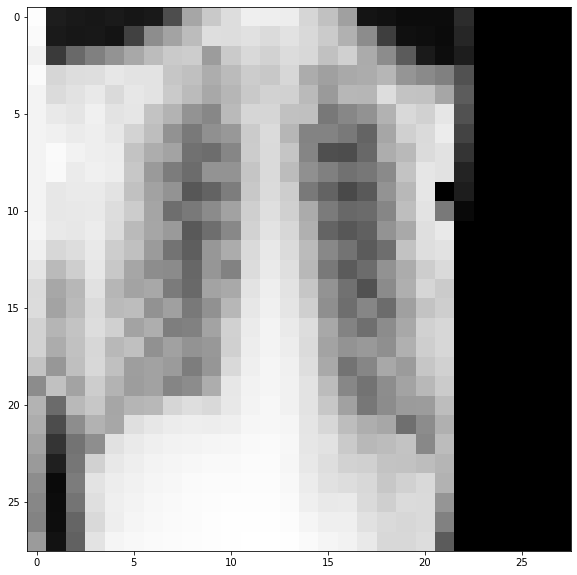

anomaly score : 1061.796142578125


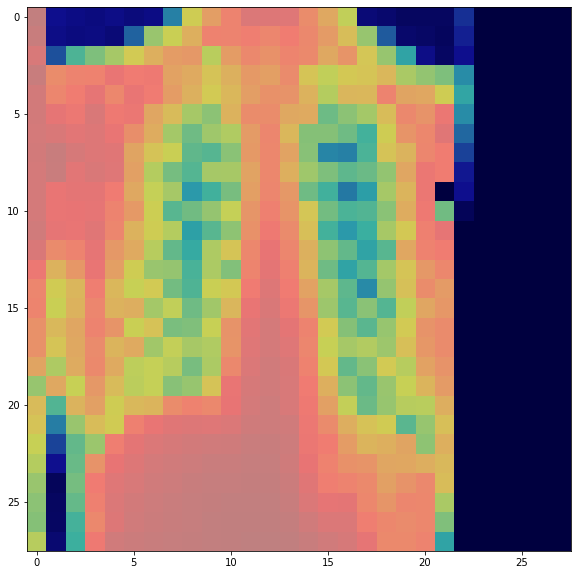

In [21]:
model = anomaly_detector()
ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 28, 28, 1))

plt.figure(figsize=(10, 10))
plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
plt.show()
print("anomaly score : " + str(ano_score))
plt.figure(figsize=(10, 10))
plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
residual = test_img.reshape(28,28) - similar_img.reshape(28,28)
plt.imshow(residual, cmap='jet', alpha=.5)
plt.show()